In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from collections import namedtuple
from scipy.stats import beta, gamma, norm, norminvgauss, triang
from scipy.interpolate import UnivariateSpline
from scipy.integrate import romberg, quad
from scipy.optimize import curve_fit
from lmfit import Model
from tqdm import tqdm, trange

In [2]:
############################
#### Physical constants ####
############################
PhysicalConstants = namedtuple('PhysicalConstants', ('g', 'rho_w', 'nu'))
CONST = PhysicalConstants(g=9.81,      # Acceleration due to gravity (m/s**2)
                          rho_w=1025,  # Density of sea water (kg/m**3)
                          nu=1.358e-6, # Kinematic viscosity of sea water (m**2/s)
                         )

# Density distribution

In [3]:
# Normal-inverse Gaussian distribution, with parameters from
# https://pubs.acs.org/doi/pdf/10.1021/acs.estlett.9b00379

loc   = 0.84
scale = 0.097
alpha = 75.1
beta  = 71.3
rv_density = norminvgauss(alpha, beta, loc, scale)

density_distribution = lambda rho  : rv_density.pdf(rho)

Text(0, 0.5, 'Probability density')

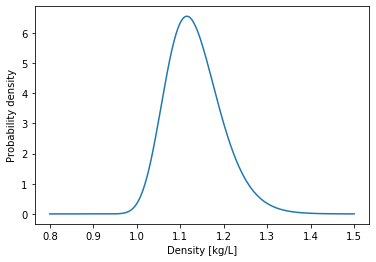

In [4]:
# Plot resulting distribution
rho = np.linspace(0.8, 1.5, 1000)
plt.plot(rho, density_distribution(rho))
plt.xlabel('Density [kg/L]')
plt.ylabel('Probability density')

# Size distribution

In [5]:
# Power law distribution, with parameters from
# https://pubs.acs.org/doi/pdf/10.1021/acs.estlett.9b00379
# Cut-offs at 20 um and 5000 um.
# Converting from number distribution to volume distribution.

# Un-normalised number distribution pdf
alpha = 1.6
powerlaw = lambda d : d ** (-alpha)
# Un-normalised volume distribution
size_distribution_unnormalised = lambda d : 4*np.pi*(d/2)**3 * powerlaw(d)
# Normalisation constant
constant = romberg(size_distribution_unnormalised, 20, 5000)
# Normalised volume distribution
size_distribution = lambda d: size_distribution_unnormalised(d) / constant

Text(0, 0.5, 'Volume distribution')

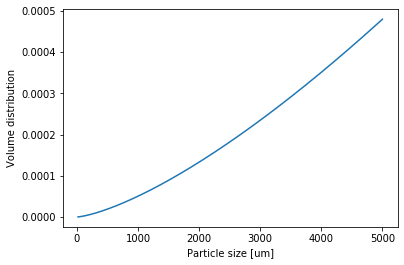

In [6]:
# Plot resulting distribution
d = np.linspace(20, 5000, 1000)
plt.plot(d, size_distribution(d))
plt.xlabel('Particle size [um]')
plt.ylabel('Volume distribution')

# Shape distribution

In [7]:
# Distribution for Corey Shape Factor (CSF)
# Sum of two Gaussian distributions, with parameters from
# https://pubs.acs.org/doi/pdf/10.1021/acs.estlett.9b00379
# (truncated at 0 and 1 and normalised)

# Parameters
f1, f2 = 0.06, 0.94
sigma1, sigma2 = 0.03, 0.19
mu1, mu2 = 0.08, 0.44
# Create two Gaussians
rv1 = norm(mu1, sigma1)
rv2 = norm(mu2, sigma2)
# Combine and normalise to compensate for truncation at 0 and 1
shape_distribution = lambda CSF : f1*rv1.pdf(CSF) / (rv1.cdf(1) - rv1.cdf(0)) + f2*rv2.pdf(CSF) / (rv2.cdf(1) - rv2.cdf(0))

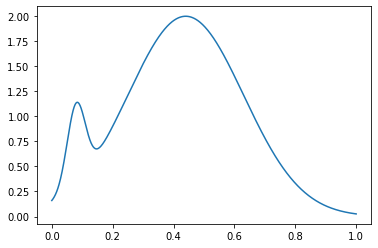

In [8]:
# Plot resulting distribution
CSF = np.linspace(0, 1, 1000)
plt.plot(CSF, shape_distribution(CSF))

# Shape distribution separately for Fibers and Other Things

In [9]:
# Create a collection of triangular distributions
# for different particle types, with parameters from
# https://pubs.acs.org/doi/pdf/10.1021/acs.estlett.9b00379

# c is a shape parameter, 0.5 = symmetric
# loc is the leftmost point
# loc + c*scale is the peak
# loc + scale is the rightmost point
c = 0.5

fragment_width  = triang(c, loc = 0.1,  scale = 0.9)
fragment_height = triang(c, loc = 0.01, scale = 0.99)

foam_width  = triang(c, loc = 0.1,  scale = 0.9)
foam_height = triang(c, loc = 0.01, scale = 0.99)

fibre_width  = triang(c, loc = 0.001, scale = 0.499)
fibre_height = triang(c, loc = 0.001, scale = 0.499)

sheet_width  = triang(c, loc = 0.1,   scale = 0.9)
sheet_height = triang(c, loc = 0.001, scale = 0.099)

pellet_width  = triang(c, loc = 0.6,  scale = 0.4)
pellet_height = triang(c, loc = 0.36, scale = 0.64)

In [10]:
def CSF(length, width, height):
    height_ = np.minimum(width, height)
    width_  = np.maximum(width, height)
    return height_ / np.sqrt(length*width_)

In [11]:
Np = 100000
# lengths all normalised to 1
lengths = np.ones(Np)

CSFs = np.zeros((Np, 5))
CSFs[:,0] = CSF(lengths, fragment_width.rvs(Np), fragment_height.rvs(Np))
CSFs[:,1] = CSF(lengths, foam_width.rvs(Np), foam_height.rvs(Np))
CSFs[:,2] = CSF(lengths, fibre_width.rvs(Np), fibre_height.rvs(Np))
CSFs[:,3] = CSF(lengths, sheet_width.rvs(Np), sheet_height.rvs(Np))
CSFs[:,4] = CSF(lengths, pellet_width.rvs(Np), pellet_height.rvs(Np))

weights = np.zeros((5))
weights[0] = 0.31  # Abundance of fragments
weights[1] = 0.035 # Abundance of foam
weights[2] = 0.485 # Abundance of fibres
weights[3] = 0.055 # Abundance of sheets
weights[4] = 0.065 # Abundance of pellets

# Reproduce Fig. 2A from Kooi & Koelmans

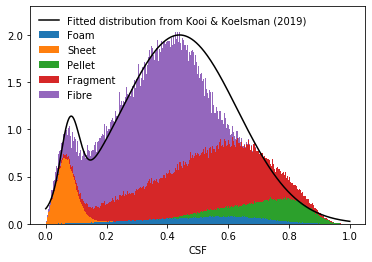

In [12]:
bins = np.linspace(0, 1, 501)
counts = np.zeros((len(bins)-1, 5))
for i in range(5):
    counts[:,i] = weights[i]*np.histogram(CSFs[:,i], bins = bins, density = True)[0]

indices = np.array([1, 3, 4, 0, 2])
labels = ['Fragment', 'Foam', 'Fibre', 'Sheet', 'Pellet']

for n, i in enumerate(indices):
    if n == 0:
        plt.bar(bins[:-1], counts[:,i], width=(bins[1]-bins[0]), label = labels[i])
    else:
        plt.bar(bins[:-1], counts[:,i], width=(bins[1]-bins[0]), label = labels[i], bottom = np.sum(counts[:,indices[:n]], axis=1))

tmp = np.linspace(0, 1, 1000)
plt.plot(tmp, shape_distribution(tmp), c = 'k', label = 'Fitted distribution from Kooi & Koelsman (2019)')
plt.legend(loc = 'upper left', frameon = False)
plt.xlabel('CSF')
plt.ylim(0, 2.3)
plt.savefig('CSF-distribution.png')

# Fit separate distributions for Fibres and Other Things

/Users/torn/.conda/envs/default/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in power
/Users/torn/.conda/envs/default/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


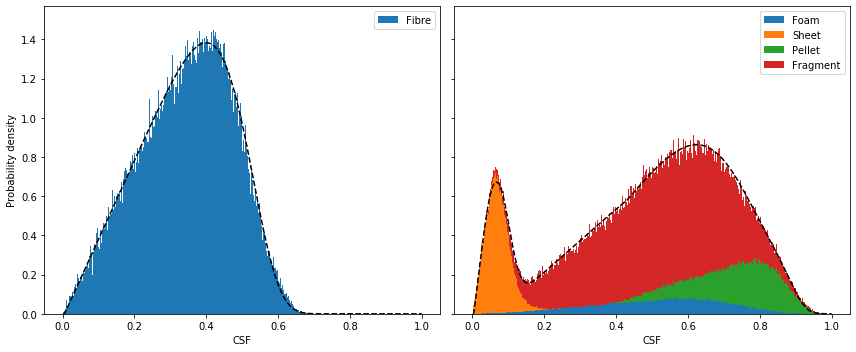

In [13]:
bins = np.linspace(0, 1, 501)
counts = np.zeros((len(bins)-1, 5))
for i in range(5):
    counts[:,i] = weights[i]*np.histogram(CSFs[:,i], bins = bins, density = True)[0]

indices = np.array([1, 3, 4, 0, 2])
labels = ['Fragment', 'Foam', 'Fibre', 'Sheet', 'Pellet']

fig, ax = plt.subplots(ncols = 2, figsize = (12,5), sharex = True, sharey = True)

# Plot fibres in left panel
ax[0].bar(bins[:-1], counts[:,2], width=(bins[1]-bins[0]), label = labels[2])
# Plot everything else in right panel
for n, i in enumerate(indices[:-1]):
    if n == 0:
        ax[1].bar(bins[:-1], counts[:,i], width=(bins[1]-bins[0]), label = labels[i])
    else:
        ax[1].bar(bins[:-1], counts[:,i], width=(bins[1]-bins[0]), label = labels[i], bottom = np.sum(counts[:,indices[:n]], axis=1))

mids = bins[:-1] + (bins[1]-bins[0])/2

# Fit distributions to each category individually
shape_pdf = lambda x, a, b, c, x0 : np.where(np.isnan(np.maximum(0, a*(x-x0)*np.exp(-b*(x-x0)**c))), 0.0, np.maximum(0, a*(x-x0)*np.exp(-b*(x-x0)**c)))
guesses = [
    (1.17, 13, 9.7, 0.0),
    (0.13, 13, 9.7, 0.0),
    (3.9, 140, 7.6, 0.0),
    (13, 3000, 3.4, 0.0),
    (0.57, 28388, 14.54, 0.4),
]
#x0s = [0, 0, 0, 0, 0.4]
popt_csf = []
for i in range(5):
    popt_csf.append(curve_fit(shape_pdf, mids, counts[:,i], p0 = guesses[i])[0])


# Non-normalised distributions
shape_distribution_fibre_unnormalised    = lambda csf : shape_pdf(csf, *popt_csf[2])
shape_distribution_nonfibre_unnormalised = lambda csf : shape_pdf(csf, *popt_csf[0])+shape_pdf(csf, *popt_csf[1])+shape_pdf(csf, *popt_csf[3])+shape_pdf(csf, *popt_csf[4])
# Normalisation constants, scaled with abundencies
# from Kooi & Koelmans (2019): 48.5% fibres, 46.5% of foam, sheets, pellets and fragments
# (not sure what happened to the missing 5%)
C_fibre    = quad(shape_distribution_fibre_unnormalised,    0, 1)[0] / 0.485
C_nonfibre = quad(shape_distribution_nonfibre_unnormalised, 0, 1)[0] / 0.465
# Normalised distributions
shape_distribution_fibre    = lambda csf : shape_distribution_fibre_unnormalised(csf) / C_fibre
shape_distribution_nonfibre = lambda csf : shape_distribution_nonfibre_unnormalised(csf) / C_nonfibre

# Plot distributions together with histogram of random samples
ax[0].plot(mids, shape_distribution_fibre(mids), '--', c = 'k', zorder = 1)    
ax[1].plot(mids, shape_distribution_nonfibre(mids), '--', c = 'k', zorder = 1)

# Plot stuff
ax[0].legend()
ax[1].legend()
ax[0].set_ylabel('Probability density')
ax[0].set_xlabel('CSF')
ax[1].set_xlabel('CSF')

plt.tight_layout()
plt.savefig('CSF-distribution.png')

# Rise and settling speeds from Waldschläger & Schüttrumpf (2019)

In [14]:
# Rise speed and Settling speed

def rise_speed_stokes(d, rho):
    '''
    d: droplet diameter (m)
    rho: droplet density (kg/m**3)
    '''
    
    # Physical constants
    nu    = CONST.nu    # Kinematic viscosity of seawater (m**2/s)
    rho_w = CONST.rho_w # Density of seawater (kg/m**3)
    g     = CONST.g     # Acceleration of gravity (m/s**2)
    # reduced gravity
    g_    = g*(rho - rho_w) / rho_w
    # calculate and return velocity (positive upwards)
    return d**2 * g_ / (18*nu)


def rise_speed_johansen(d, rho):
    '''
    Calculate the rise speed (m/s) of a droplet due to buoyancy.
    This scheme uses Stokes' law at small Reynolds numbers, with
    a harmonic transition to a constant drag coefficient at high
    Reynolds numbers.
    
    See Johansen (2000), Eq. (14) for details.
    
    d: droplet diameter (m)
    rho: droplet density (kg/m**3)
    '''
    # Physical constants
    pref  = 1.054       # Numerical prefactor
    nu    = CONST.nu    # Kinematic viscosity of seawater (m**2/s)
    rho_w = CONST.rho_w # Density of seawater (kg/m**3)
    g = CONST.g         # Acceleration of gravity (m/s**2)
    
    g_    = g*(rho_w - rho) / rho_w
    w1    = d**2 * g_ / (18*nu)
    w2    = np.sqrt(d*abs(g_)) * pref * np.sign(g_)
    return w1*w2/(w1+w2)


def rise_speed_CD(d, rho, CD):
    g_ = CONST.g*(rho - CONST.rho_w)/CONST.rho_w
    return np.sqrt(4*d*np.abs(g_)/(3*CD)) * np.sign(g_)


def CD_iterator(CD_func, d, rho, CSF, rtol = 1e-6, maxiter = 20):
    # Drag coefficients are given implicitly as a function of Re.
    # Solve for CD with iterative procedure,
    # start by guessing Re from Stokes' law.
    
    # Initial guess at a Reynolds number from Stokes' law
    Re0 = np.abs(rise_speed_stokes(d, rho)) * d / CONST.nu
    # Iterate until tolerance met, or maxiter
    Re = Re0
    for n in range(maxiter):
        # Calculate drag coefficient
        CD = CD_func(Re, CSF)
        # Calculate new Reynolds number
        Re = np.abs(rise_speed_CD(d, rho, CD)) * d / CONST.nu
        # Check for convergence
        if not np.any(np.abs(Re0 - Re)/Re0 < rtol):
            break
        Re0 = Re
    return CD


def CD_pellet_sinking(Re, CSF):
    # Drag coefficient for sinking pellets from Eq. (10) in
    # https://pubs.acs.org/doi/pdf/10.1021/acs.est.8b06794
    return 3 / (CSF*Re**(1/3))

def CD_fibre_sinking(Re, CSF):
    # Drag coefficient for sinking fibres from Eq. (11) in
    # https://pubs.acs.org/doi/pdf/10.1021/acs.est.8b06794
    return 4.7/np.sqrt(Re) + np.sqrt(CSF)

def CD_pellet_rising(Re, CSF):
    # Drag coefficient for rising pellets from Eq. (12) in
    # https://pubs.acs.org/doi/pdf/10.1021/acs.est.8b06794
    # Note: Hard-coding the Powers roundness factor to 3.5
    P = 3.5
    return (20/Re + 10/np.sqrt(Re) + np.sqrt(1.195 - CSF))*(6/P)**(1-CSF)

def CD_fibre_rising(Re, CSF):
    # Drag coefficient for sinking fibres from Eq. (13) in
    # https://pubs.acs.org/doi/pdf/10.1021/acs.est.8b06794
    return 10/np.sqrt(Re) + np.sqrt(CSF)

# Some tests of rising/settling speeds

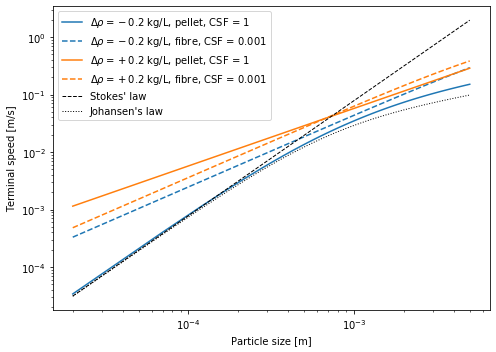

In [15]:
# Compare to Stokes' law for small spheres
d = np.linspace(20e-6, 5e-3, 100)

fig = plt.figure(figsize = (7,5))

rho = 825 # kg/m3
CD = CD_iterator(CD_pellet_rising, d, rho, 1)
l, = plt.plot(d, -rise_speed_CD(d, rho, CD), label = f'$\Delta \\rho = -0.2$ kg/L, pellet, CSF = 1')
CD = CD_iterator(CD_fibre_rising, d, rho, 0.001)
plt.plot(d, -rise_speed_CD(d, rho, CD), '--', c = l.get_color(), label = f'$\Delta \\rho = -0.2$ kg/L, fibre, CSF = 0.001')

rho = 1225 # kg/m3
CD = CD_iterator(CD_pellet_sinking, d, rho, 1)
l, = plt.plot(d, rise_speed_CD(d, rho, CD), label = f'$\Delta \\rho = +0.2$ kg/L, pellet, CSF = 1')
CD = CD_iterator(CD_fibre_sinking, d, rho, 0.001)
plt.plot(d, rise_speed_CD(d, rho, CD), '--', c = l.get_color(), label = f'$\Delta \\rho = +0.2$ kg/L, fibre, CSF = 0.001')


plt.plot(d, rise_speed_stokes(d, rho), '--', c = 'k', lw = 1, label = f"Stokes' law")
plt.plot(d, -rise_speed_johansen(d, rho), ':', c = 'k', lw = 1, label = f"Johansen's law")

plt.legend(loc = 'upper left')
plt.xlabel('Particle size [m]')
plt.ylabel('Terminal speed [m/s]')

plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.savefig('speed_comparison.png', dpi = 120)

# Combine everything and create speed distribution

In [16]:
Nsize = 701
Ndens = 1001
Ncsf  = 201

# Span range of sizes, densities and CSFs
sizes = np.linspace(20, 5000, Nsize) # micrometers
rhos  = np.linspace(0.8, 1.5, Ndens) # kg/L
CSFs  = np.linspace(0, 1, Ncsf+1)[1:] # remove zero as it is unattainable, and messes up the speeds

# Calculate probabilities
prob_sizes        = size_distribution(sizes)
prob_rhos         = density_distribution(rhos)
prob_CSF_fibre    = shape_distribution_fibre(CSFs)
prob_CSF_nonfibre = shape_distribution_nonfibre(CSFs)

# Rank 3 arrays for speeds
speeds_fibre    = np.zeros((Nsize, Ndens, Ncsf))
speeds_nonfibre = np.zeros((Nsize, Ndens, Ncsf))

# Rank 3 arrays for probabilities
probability_fibre    = np.zeros((Nsize, Ndens, Ncsf))
probability_nonfibre = np.zeros((Nsize, Ndens, Ncsf))

# Calculate speeds and probabilities for all combinations
# of size, density and CSF, for fibre and nonfibre
for i in range(Ncsf):
    for j in range(Ndens):
        rho = rhos[j]
        CSF = CSFs[i]
        # Convert size to m and density to kg/m3 when passing to function
        speeds_fibre[:,j,i]    = rise_speed_CD(1e-6*sizes, 1e3*rho, CD_iterator(CD_fibre_rising, sizes, rho, CSF))
        speeds_nonfibre[:,j,i] = rise_speed_CD(1e-6*sizes, 1e3*rho, CD_iterator(CD_pellet_rising, sizes, rho, CSF))
        # probability
        probability_fibre[:,j,i]    = prob_sizes * prob_rhos[j] * prob_CSF_fibre[i]
        probability_nonfibre[:,j,i] = prob_sizes * prob_rhos[j] * prob_CSF_nonfibre[i]

/Users/torn/.conda/envs/default/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in power


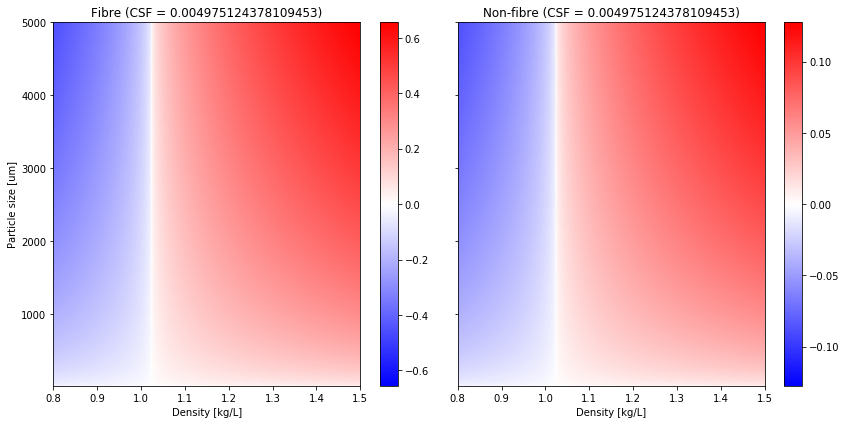

In [17]:
# Select CSF from array above
iCSF = 0

fig, ax = plt.subplots(ncols = 2, figsize = (12,6), sharex=True, sharey=True)

lim = max(np.amax(speeds_fibre[:,:,iCSF]), np.amax(-speeds_fibre[:,:,iCSF]))
mesh = ax[0].pcolormesh(rhos, sizes, speeds_fibre[:,:,iCSF], vmin = -lim, vmax = lim, cmap = plt.get_cmap('bwr'))
plt.colorbar(mesh, ax = ax[0])

lim = max(np.amax(speeds_nonfibre[:,:,iCSF]), np.amax(-speeds_nonfibre[:,:,iCSF]))
mesh = ax[1].pcolormesh(rhos, sizes, speeds_nonfibre[:,:,iCSF], vmin = -lim, vmax = lim, cmap = plt.get_cmap('bwr'))
plt.colorbar(mesh, ax = ax[1])

ax[0].set_title(f'Fibre (CSF = {CSFs[iCSF]})')
ax[1].set_title(f'Non-fibre (CSF = {CSFs[iCSF]})')

ax[0].set_ylabel('Particle size [um]')
ax[0].set_xlabel('Density [kg/L]')
ax[1].set_xlabel('Density [kg/L]')
plt.tight_layout()

0.4849965598886641
0.46499711261340837
1.0017086863859168
0.9999752466768358
0.48581324111792784
0.4657801169580609


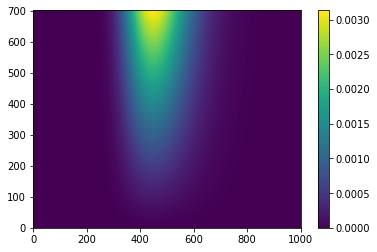

In [18]:
plt.pcolormesh(probability_fibre[:,:,50])
plt.colorbar()

drho = rhos[1] - rhos[0]
dCSF = CSFs[1] - CSFs[0]
dsize = sizes[1] - sizes[0]

print(np.sum(prob_CSF_fibre)*dCSF)
print(np.sum(prob_CSF_nonfibre)*dCSF)

print(np.sum(prob_sizes)*dsize)
print(np.sum(prob_rhos)*drho)

print(np.sum(probability_fibre)*drho*dCSF*dsize)
print(np.sum(probability_nonfibre)*drho*dCSF*dsize)

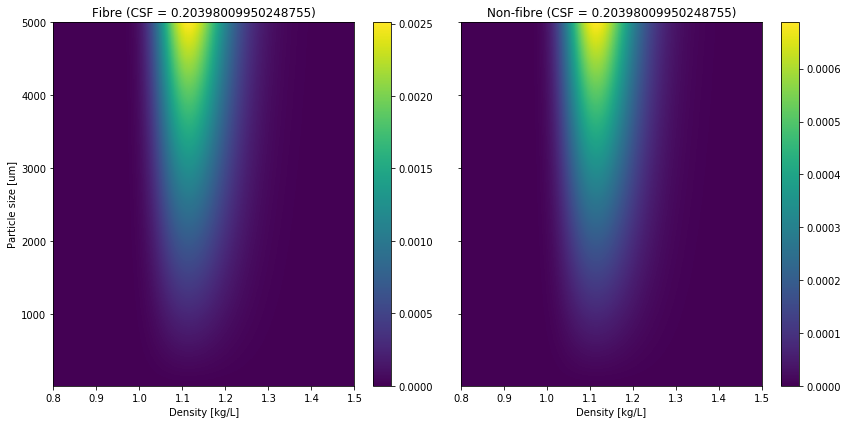

In [19]:
# Select CSF from array above
iCSF = 40

fig, ax = plt.subplots(ncols = 2, figsize = (12,6), sharex=True, sharey=True)

mesh = ax[0].pcolormesh(rhos, sizes, probability_fibre[:,:,iCSF])
plt.colorbar(mesh, ax = ax[0])

mesh = ax[1].pcolormesh(rhos, sizes, probability_nonfibre[:,:,iCSF])
plt.colorbar(mesh, ax = ax[1])

ax[0].set_title(f'Fibre (CSF = {CSFs[iCSF]})')
ax[1].set_title(f'Non-fibre (CSF = {CSFs[iCSF]})')

ax[0].set_ylabel('Particle size [um]')
ax[0].set_xlabel('Density [kg/L]')
ax[1].set_xlabel('Density [kg/L]')
plt.tight_layout()

# Create total speed distribution by histogramming all the values above

In [20]:
vol = dsize*drho*dCSF
bins = np.linspace(-0.2, 0.4, 513)
total_speed_density_fibre, _    = np.histogram(speeds_fibre.flatten(), weights=(probability_fibre*vol).flatten(), bins = bins, density = True)
total_speed_density_nonfibre, _ = np.histogram(speeds_nonfibre.flatten(), weights=(probability_nonfibre*vol).flatten(), bins = bins, density = True)
mids = bins[:-1] + (bins[1] - bins[0])/2

# Attempt to fit various models

In [21]:
# Fit a cubic spline with some smoothing
f_fibre    = UnivariateSpline(mids, total_speed_density_fibre, s = 0.0005)
f_nonfibre = UnivariateSpline(mids, total_speed_density_nonfibre, s = 0.0005)
# Fit a cubic spline to the exp of the data, to force positive values
f_exp_fibre    = UnivariateSpline(mids, np.exp(total_speed_density_fibre), s = 0.00001)
f_exp_nonfibre = UnivariateSpline(mids, np.exp(total_speed_density_nonfibre), s = 0.00001)

# fit a gaussian to the positive part of the data
gauss = lambda x, c, mu, sigma : np.exp(-(x - mu)**2/(2*sigma**2))/(np.sqrt(2*np.pi)*sigma)
popt_gauss, _ = curve_fit(gauss, mids[mids > 0], total_speed_density_fibre[mids > 0])

# Fit a gamma distribution to the positive part of the data
gamma_pdf = lambda x, a, loc, scale : gamma(a, loc, scale).pdf(x)
popt_gamma, _ = curve_fit(gamma_pdf, mids[mids > 0], total_speed_density_fibre[mids > 0], p0 = (5, 0, 0.1))

/Users/torn/.conda/envs/default/lib/python3.6/site-packages/scipy/optimize/minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


# Plot total speed distribution and fitted splines for fibres

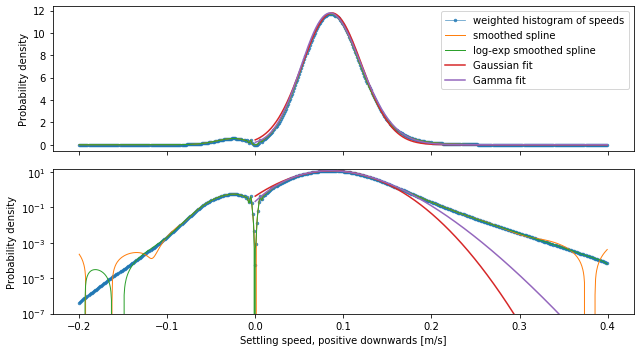

In [22]:
# Plot twice, on linear scale and log scale
fig, ax = plt.subplots(nrows = 2, figsize = (9,5), sharex = True)

# Higher resolution x-values for spline plotting
tmp = np.linspace(mids[0], mids[-1], 1000)
for i in range(2):
    ax[i].plot(mids, total_speed_density_fibre, marker = '.', lw = 0.75, markersize = 5, alpha = 0.75, label = 'weighted histogram of speeds')
    ax[i].plot(tmp, f_fibre(tmp), label = 'smoothed spline', lw = 1)
    ax[i].plot(tmp, np.log(f_exp_fibre(tmp)), label = 'log-exp smoothed spline', lw = 1)
    
    ax[i].plot(tmp[tmp>0], gauss(tmp[tmp>0], *popt_gauss), label = 'Gaussian fit')
    ax[i].plot(tmp[tmp>0], gamma_pdf(tmp[tmp>0], *popt_gamma), label = 'Gamma fit')
    
    ax[i].set_ylabel('Probability density')

ax[0].legend(loc = 'upper right')
ax[1].set_yscale('log')
ax[1].set_xlabel('Settling speed, positive downwards [m/s]')
ax[1].set_ylim(1e-7, 15)
plt.tight_layout()

# Plot total speed distribution and fitted splines for non-fibres

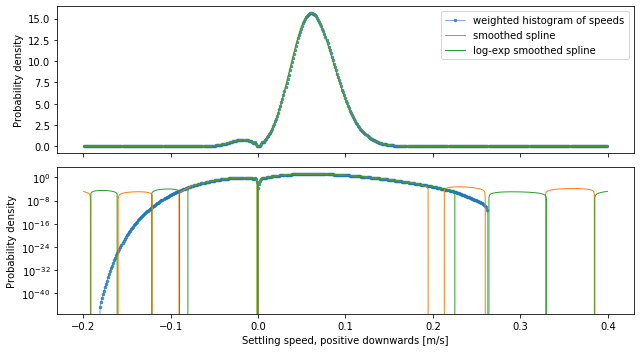

In [23]:
# Plot twice, on linear scale and log scale
fig, ax = plt.subplots(nrows = 2, figsize = (9,5), sharex = True)

# Higher resolution x-values for spline plotting
tmp = np.linspace(mids[0], mids[-1], 1000)
for i in range(2):
    ax[i].plot(mids, total_speed_density_nonfibre, marker = '.', lw = 0.75, markersize = 5, alpha = 0.75, label = 'weighted histogram of speeds')
    ax[i].plot(tmp, f_nonfibre(tmp), label = 'smoothed spline', lw = 1)
    ax[i].plot(tmp, np.log(f_exp_nonfibre(tmp)), label = 'log-exp smoothed spline', lw = 1)
    ax[i].set_ylabel('Probability density')

ax[0].legend(loc = 'upper right')
ax[1].set_yscale('log')
ax[1].set_xlabel('Settling speed, positive downwards [m/s]')
plt.tight_layout()

# Zoom in on zero

NameError: name 'f' is not defined

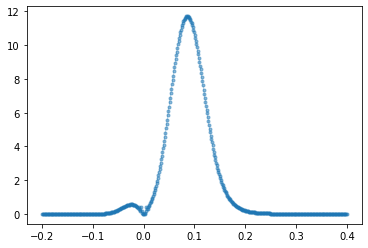

In [24]:
plt.plot(mids, total_speed_density_fibre, marker = '.', lw = 0.5, alpha = 0.5, label = 'weighted histogram of speeds')

tmp = np.linspace(mids[0], mids[-1], 1000)
plt.plot(tmp, f(tmp), label = 'smoothed spline')
plt.plot(tmp, np.log(f_exp(tmp)), label = 'log-exp smoothed spline')

plt.legend()
plt.xlim(-0.02, 0.02)
plt.ylim(-0.03, 1.5)

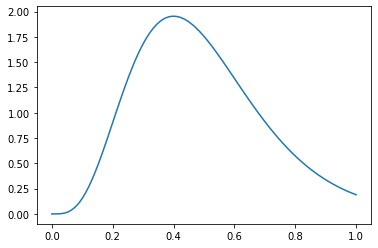

In [25]:
x = np.linspace(0,1,100)
#plt.plot(x, gamma_pdf(x, *popt_gamma))
plt.plot(x, gamma(5, 0.0, 0.1).pdf(x))

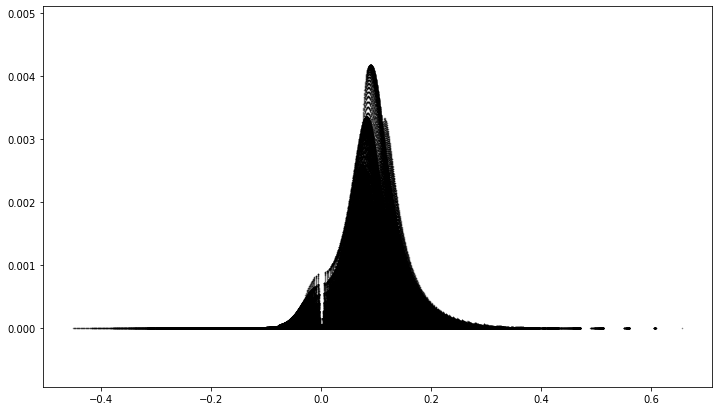

In [26]:
skip = 100
fig = plt.figure(figsize = (12, 7))

plt.scatter(speeds_fibre.flatten()[::skip], probability_fibre.flatten()[::skip], marker = '.', s = 1, c = 'k', alpha = 0.5)

# Monte Carlo sampling to find speed distribution

In [41]:
# Number of samples
Np = 1000000

# Density distribution can be sampled directly
random_densities = rv_density.rvs(Np)

# Size distribution must be sampled via numerically inverted CDF
tmp = np.linspace(20, 5000, 10000)
cdf_size = np.cumsum(size_distribution(tmp))*(tmp[1]-tmp[0])
inverse_cdf_size = UnivariateSpline(cdf_size, tmp, s = 0)
random_sizes = inverse_cdf_size(np.random.random(Np))

# Shape distributions must be sampled via numerically inverted CDFs
tmp = np.linspace(0, 1, 2001)
cdf_shape_fibre = np.cumsum(shape_distribution_fibre(tmp))*(tmp[1]-tmp[0]) / 0.485
mask = (cdf_shape_fibre > cdf_shape_fibre[0]) & (cdf_shape_fibre < cdf_shape_fibre[-1])
cdf_shape_fibre = np.concatenate((np.array([0.0]), cdf_shape_fibre[mask], np.array([cdf_shape_fibre[-1],]))) / cdf_shape_fibre[-1]
tmp = np.concatenate((np.array([tmp[np.arange(len(mask))[mask][0]-1]]), tmp[mask], np.array([tmp[np.arange(len(mask))[mask][-1]+1]])))
inverse_cdf_shape_fibre = UnivariateSpline(cdf_shape_fibre, tmp, s = 0, k = 3)
random_shapes = np.minimum(inverse_cdf_shape_fibre(np.random.random(Np)), 1)

/Users/torn/.conda/envs/default/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in power


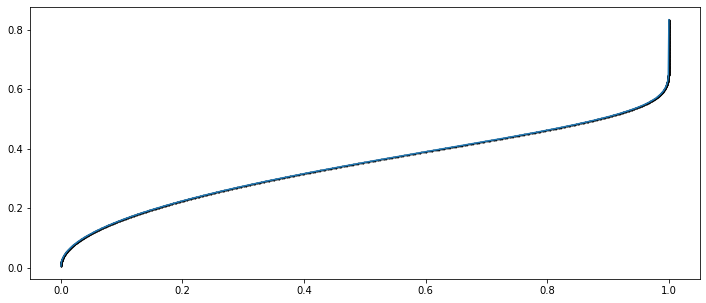

In [42]:
fig = plt.figure(figsize = (12, 5))
tmp2 = np.linspace(0, 1, 1000)
plt.plot(tmp2, inverse_cdf_shape_fibre(tmp2))
plt.scatter(cdf_shape_fibre, tmp, s = 2, marker = '.', c = 'k')
#plt.xlim(1 - 3e-7, 1)

/Users/torn/.conda/envs/default/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in power


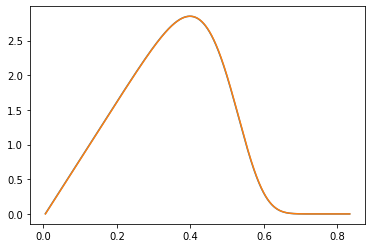

In [43]:
plt.plot(tmp[:-1], (cdf_shape_fibre[1:] - cdf_shape_fibre[:-1])/(tmp[1:] - tmp[:-1]) )
plt.plot(tmp, shape_distribution_fibre(tmp) / 0.485)

/Users/torn/.conda/envs/default/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in power


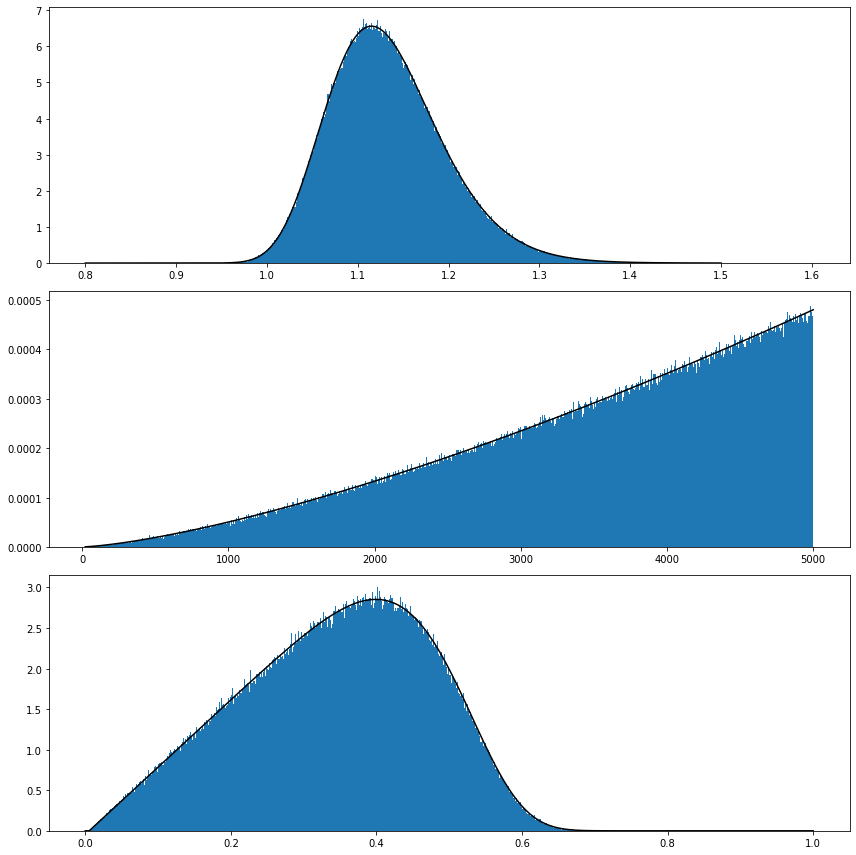

In [44]:
fig, ax = plt.subplots(nrows = 3, figsize = (12, 12))

tmp = np.linspace(0.8, 1.5, 1000)
ax[0].plot(tmp, density_distribution(tmp), c = 'k')
ax[0].hist(random_densities, bins = 1000, density = True)

tmp = np.linspace(20, 5000, 1000)
ax[1].plot(tmp, size_distribution(tmp), c = 'k')
ax[1].hist(random_sizes, bins = 1000, density = True)

tmp = np.linspace(0, 1, 1000)
ax[2].plot(tmp, shape_distribution_fibre(tmp)/0.485, c = 'k')
ax[2].hist(random_shapes, bins = 1001, density = True)

plt.tight_layout()

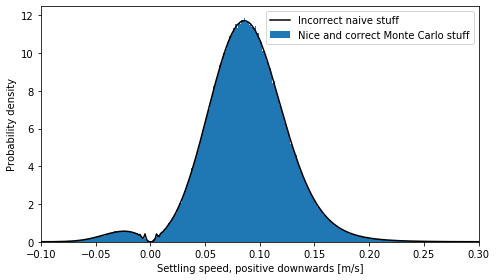

In [45]:
CDs = CD_iterator(CD_fibre_rising, random_sizes, random_densities, random_shapes)
speeds = rise_speed_CD(1e-6*random_sizes, 1e3*random_densities, CDs)

fig = plt.figure(figsize = (7, 4))
plt.hist(speeds, bins = 512, density = True, label = 'Nice and correct Monte Carlo stuff')
plt.plot(mids, total_speed_density_fibre, c = 'k', label = 'Incorrect naive stuff')
plt.xlim(-0.1, 0.3)
plt.legend()
plt.xlabel('Settling speed, positive downwards [m/s]')
plt.ylabel('Probability density')
plt.tight_layout()


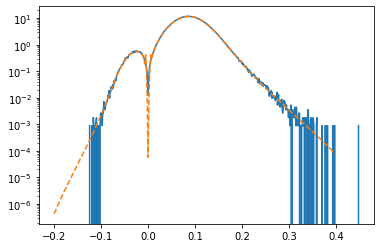

In [46]:
h, b = np.histogram(speeds, bins = 512, density = True)
m = b[:-1] + (b[1]-b[0])/2

plt.plot(m, h)


plt.plot(mids, total_speed_density_fibre, '--')

plt.yscale('log')

In [ ]:
plt.plot(mids, total_speed_density_fibre)
plt.plot(mids, total_speed_density_nonfibre)
plt.plot(mids, total_speed_density_fibre + total_speed_density_nonfibre)
plt.yscale('log')
plt.ylim(1e-6, 25)


# Repeated Monte Carlo sampling

In [170]:
#############################################
#### Establish inverse CDFs for sampling ####
#############################################

# Size distribution must be sampled via numerically inverted CDF
tmp = np.linspace(20, 5000, 10000)
cdf_size = np.cumsum(size_distribution(tmp))*(tmp[1]-tmp[0])
inverse_cdf_size = UnivariateSpline(cdf_size, tmp, s = 0)

# Fibre shape distributions must be sampled via numerically inverted CDFs
tmp = np.linspace(0, 1, 2001)
cdf_shape_fibre = np.cumsum(shape_distribution_fibre(tmp))*(tmp[1]-tmp[0]) / 0.485
mask = (cdf_shape_fibre > cdf_shape_fibre[0]) & (cdf_shape_fibre < cdf_shape_fibre[-1])
cdf_shape_fibre = np.concatenate((np.array([0.0]), cdf_shape_fibre[mask], np.array([cdf_shape_fibre[-1],]))) / cdf_shape_fibre[-1]
tmp = np.concatenate((np.array([tmp[np.arange(len(mask))[mask][0]-1]]), tmp[mask], np.array([tmp[np.arange(len(mask))[mask][-1]+1]])))
inverse_cdf_shape_fibre = UnivariateSpline(cdf_shape_fibre, tmp, s = 0, k = 3)

# Non-fibre shape distributions must be sampled via numerically inverted CDFs
tmp = np.linspace(0, 1, 2001)
cdf_shape_nonfibre = np.cumsum(shape_distribution_nonfibre(tmp))*(tmp[1]-tmp[0]) / 0.465
mask = (cdf_shape_nonfibre > cdf_shape_nonfibre[0]) & (cdf_shape_nonfibre < cdf_shape_nonfibre[-1])
cdf_shape_nonfibre = np.concatenate((np.array([0.0]), cdf_shape_nonfibre[mask], np.array([cdf_shape_nonfibre[-1],]))) / cdf_shape_nonfibre[-1]
tmp = np.concatenate((np.array([tmp[np.arange(len(mask))[mask][0]-1]]), tmp[mask], np.array([tmp[np.arange(len(mask))[mask][-1]+1]])))
inverse_cdf_shape_nonfibre = UnivariateSpline(cdf_shape_nonfibre, tmp, s = 0, k = 3)


# Repeatedly draw samples, and make histograms of speeds
Ndraws = 1000
Nbins  = 512*3
bins = np.linspace(-0.1838, 0.32, Nbins+1)
hist_fibre = np.zeros((Ndraws, Nbins))
# Number of samples
Np = 1000000

for i in trange(Ndraws):
    # Density distribution can be sampled directly
    random_densities = rv_density.rvs(Np)
    # Size distribution must be sampled via numerically inverted CDF
    random_sizes = inverse_cdf_size(np.random.random(Np))
    # Shape distributions must be sampled via numerically inverted CDFs
    random_shapes_fibre = np.minimum(inverse_cdf_shape_fibre(np.random.random(Np)), 1)
#    random_shapes_nonfibre = np.minimum(inverse_cdf_shape_fibre(np.random.random(Np)), 1)
    
    CDs = CD_iterator(CD_fibre_rising, random_sizes, random_densities, random_shapes_fibre)
    speeds = rise_speed_CD(1e-6*random_sizes, 1e3*random_densities, CDs)
    # Store histogram of speeds
    hist_fibre[i,:] = np.histogram(speeds, bins, density = True)[0]

/Users/torn/.conda/envs/default/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in power
100%|██████████| 1000/1000 [36:42<00:00,  2.20s/it]


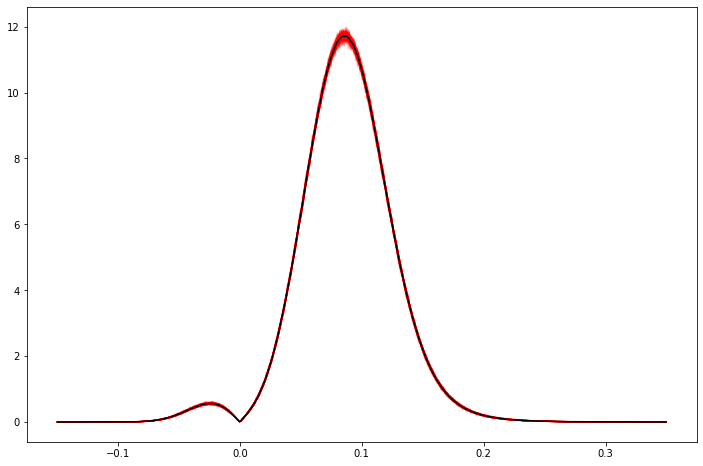

In [73]:
fig = plt.figure(figsize = (12,8))
mids = bins[1:] - (bins[1] - bins[0])/2
plt.plot(mids, hist_fibre.T, alpha = 0.2, c = 'r', lw = 1)
plt.plot(mids, np.mean(hist_fibre, axis = 0), c = 'k', lw = 1.5)

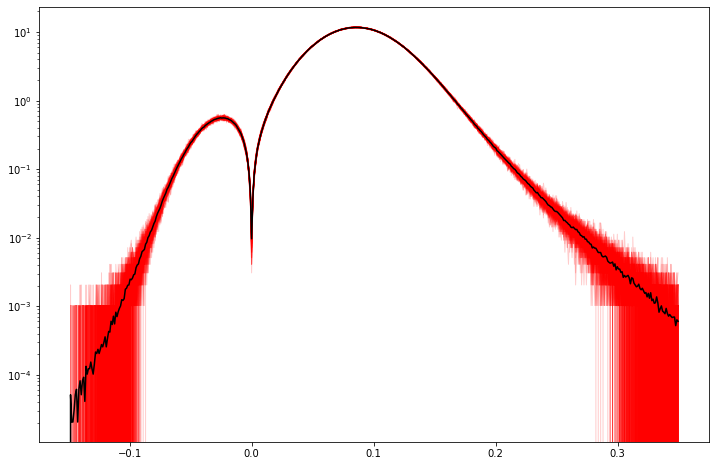

In [74]:
fig = plt.figure(figsize = (12,8))
mids = bins[1:] - (bins[1] - bins[0])/2
plt.plot(mids, hist_fibre.T, alpha = 0.2, c = 'r', lw = 1)
plt.plot(mids, np.mean(hist_fibre, axis = 0), c = 'k', lw = 1.5)
plt.yscale('log')

In [171]:
np.save('hist_fibre.npy', hist_fibre)

In [172]:
#############################################
#### Establish inverse CDFs for sampling ####
#############################################

# Size distribution must be sampled via numerically inverted CDF
tmp = np.linspace(20, 5000, 10000)
cdf_size = np.cumsum(size_distribution(tmp))*(tmp[1]-tmp[0])
inverse_cdf_size = UnivariateSpline(cdf_size, tmp, s = 0)

# Fibre shape distributions must be sampled via numerically inverted CDFs
tmp = np.linspace(0, 1, 2001)
cdf_shape_fibre = np.cumsum(shape_distribution_fibre(tmp))*(tmp[1]-tmp[0]) / 0.485
mask = (cdf_shape_fibre > cdf_shape_fibre[0]) & (cdf_shape_fibre < cdf_shape_fibre[-1])
cdf_shape_fibre = np.concatenate((np.array([0.0]), cdf_shape_fibre[mask], np.array([cdf_shape_fibre[-1],]))) / cdf_shape_fibre[-1]
tmp = np.concatenate((np.array([tmp[np.arange(len(mask))[mask][0]-1]]), tmp[mask], np.array([tmp[np.arange(len(mask))[mask][-1]+1]])))
inverse_cdf_shape_fibre = UnivariateSpline(cdf_shape_fibre, tmp, s = 0, k = 3)

# Non-fibre shape distributions must be sampled via numerically inverted CDFs
tmp = np.linspace(0, 1, 2001)
cdf_shape_nonfibre = np.cumsum(shape_distribution_nonfibre(tmp))*(tmp[1]-tmp[0]) / 0.465
mask = (cdf_shape_nonfibre > cdf_shape_nonfibre[0]) & (cdf_shape_nonfibre < cdf_shape_nonfibre[-1])
cdf_shape_nonfibre = np.concatenate((np.array([0.0]), cdf_shape_nonfibre[mask], np.array([cdf_shape_nonfibre[-1],]))) / cdf_shape_nonfibre[-1]
tmp = np.concatenate((np.array([tmp[np.arange(len(mask))[mask][0]-1]]), tmp[mask], np.array([tmp[np.arange(len(mask))[mask][-1]+1]])))
inverse_cdf_shape_nonfibre = UnivariateSpline(cdf_shape_nonfibre, tmp, s = 0, k = 3)


# Repeatedly draw samples, and make histograms of speeds
Ndraws = 1000
Nbins  = 512*3
bins = np.linspace(-0.1838, 0.32, Nbins+1)
hist_nonfibre = np.zeros((Ndraws, Nbins))
# Number of samples
Np = 1000000

for i in trange(Ndraws):
    # Density distribution can be sampled directly
    random_densities = rv_density.rvs(Np)
    # Size distribution must be sampled via numerically inverted CDF
    random_sizes = inverse_cdf_size(np.random.random(Np))
    # Shape distributions must be sampled via numerically inverted CDFs
    random_shapes_nonfibre = np.minimum(inverse_cdf_shape_nonfibre(np.random.random(Np)), 1)
#    random_shapes_nonfibre = np.minimum(inverse_cdf_shape_fibre(np.random.random(Np)), 1)
    
    CDs = CD_iterator(CD_pellet_rising, random_sizes, random_densities, random_shapes_nonfibre)
    speeds = rise_speed_CD(1e-6*random_sizes, 1e3*random_densities, CDs)
    # Store histogram of speeds
    hist_nonfibre[i,:] = np.histogram(speeds, bins, density = True)[0]

/Users/torn/.conda/envs/default/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in power
100%|██████████| 1000/1000 [39:23<00:00,  2.36s/it]


In [173]:
np.save('hist_nonfibre.npy', hist_nonfibre)

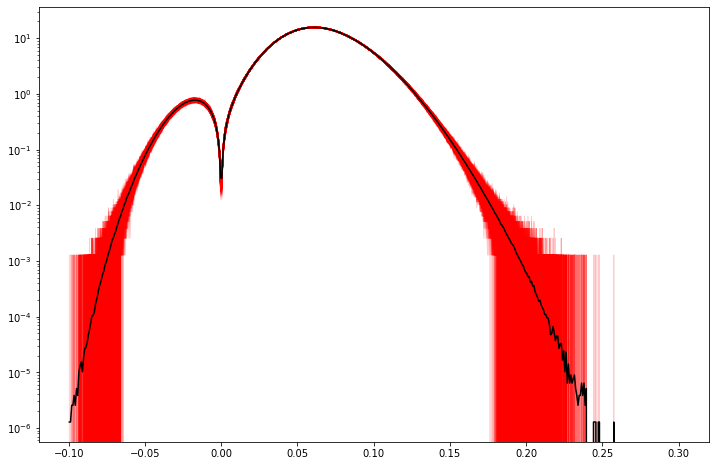

In [70]:
fig = plt.figure(figsize = (12,8))
mids = bins[1:] - (bins[1] - bins[0])/2
plt.plot(mids, hist_nonfibre.T, alpha = 0.2, c = 'r', lw = 1)
plt.plot(mids, np.mean(hist_nonfibre, axis = 0), c = 'k', lw = 1.5)
plt.yscale('log')

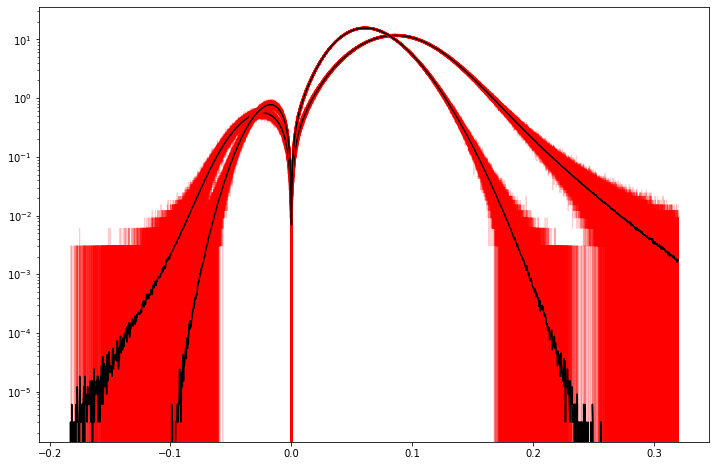

In [175]:
fig = plt.figure(figsize = (12,8))

bins_fibre = np.linspace(-0.1838, 0.32, 512*3+1)
mids_fibre = bins_fibre[1:] - (bins_fibre[1] - bins_fibre[0])/2

bins_nonfibre = bins_fibre
mids_nonfibre = bins_nonfibre[1:] - (bins_nonfibre[1] - bins_nonfibre[0])/2


plt.plot(mids_fibre, hist_fibre.T, alpha = 0.2, c = 'r', lw = 1)
plt.plot(mids_fibre, np.mean(hist_fibre, axis = 0), c = 'k', lw = 1.5)

plt.plot(mids_nonfibre, hist_nonfibre.T, alpha = 0.2, c = 'r', lw = 1)
plt.plot(mids_nonfibre, np.mean(hist_nonfibre, axis = 0), c = 'k', lw = 1.5)

plt.yscale('log')

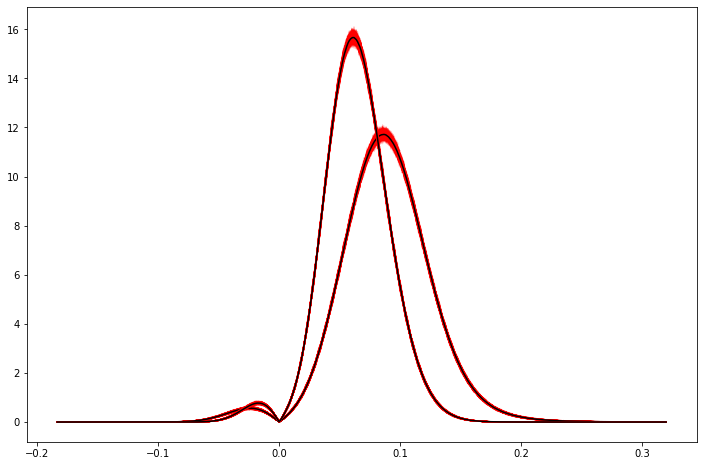

In [148]:
fig = plt.figure(figsize = (12,8))

bins_fibre = np.linspace(-0.1838, 0.32, Nbins)
mids_fibre = bins_fibre[1:] - (bins_fibre[1] - bins_fibre[0])/2

bins_nonfibre = bins_fibre
mids_nonfibre = bins_nonfibre[1:] - (bins_nonfibre[1] - bins_nonfibre[0])/2


plt.plot(mids_fibre, hist_fibre.T, alpha = 0.2, c = 'r', lw = 1)
plt.plot(mids_fibre, np.mean(hist_fibre, axis = 0), c = 'k', lw = 1.5)

plt.plot(mids_nonfibre, hist_nonfibre.T, alpha = 0.2, c = 'r', lw = 1)
plt.plot(mids_nonfibre, np.mean(hist_nonfibre, axis = 0), c = 'k', lw = 1.5)

#plt.yscale('log')

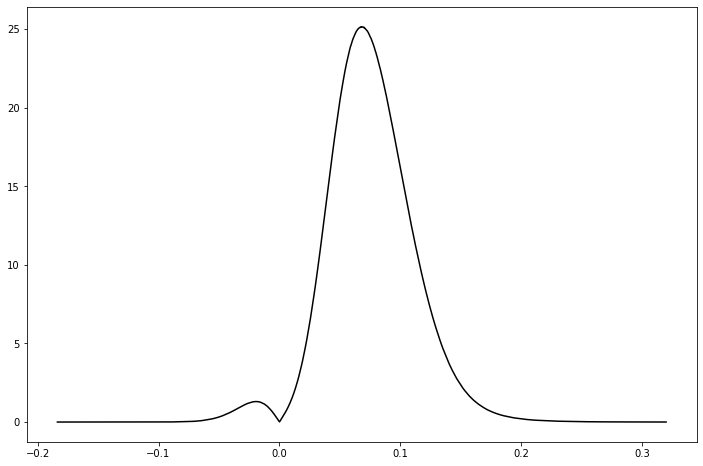

In [176]:
fig = plt.figure(figsize = (12,8))

bins_fibre = np.linspace(-0.1838, 0.32, 512*3+1)
mids_fibre = bins_fibre[1:] - (bins_fibre[1] - bins_fibre[0])/2

bins_nonfibre = bins_fibre
mids_nonfibre = bins_nonfibre[1:] - (bins_nonfibre[1] - bins_nonfibre[0])/2


plt.plot(mids_fibre, np.mean(hist_fibre, axis = 0) + np.mean(hist_nonfibre, axis = 0), c = 'k', lw = 1.5)

#plt.yscale('log')

0.9499999999999429
1.0000000000000002
1.0000000000000848
0.9999999999999999


<BarContainer object of 512 artists>

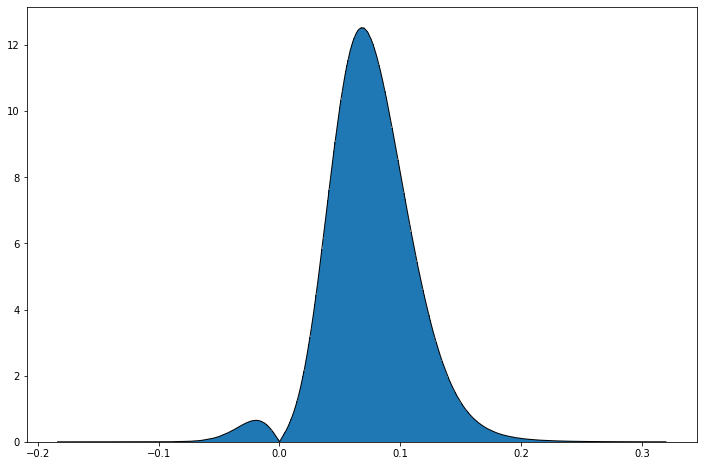

In [191]:
N = 512
step = int((512*3)/N)

dx = mids_fibre[1] - mids_fibre[0]
hist = 0.485*np.mean(hist_fibre, axis = 0) + 0.465*np.mean(hist_nonfibre, axis = 0)
print(dx*np.sum(hist))
hist = hist / (dx*np.sum(hist))
print(dx*np.sum(hist))
mids = mids_fibre

hist_subsampled = [np.mean(hist[i*step:(i+1)*step]) for i in range(N)]
mids_subsampled = [np.mean(mids[i*step:(i+1)*step]) for i in range(N)]
dx_subsampled = mids_subsampled[1] - mids_subsampled[0]
print(dx_subsampled*np.sum(hist_subsampled))
hist_subsampled = hist_subsampled / (dx_subsampled*np.sum(hist_subsampled))
print(dx_subsampled*np.sum(hist_subsampled))

fig = plt.figure(figsize = (12,8))

plt.plot(mids, hist, c = 'k', lw = 1) 
plt.bar(mids_subsampled, hist_subsampled, width = dx_subsampled)

In [194]:
np.save('speed_distribution_1536_bins_density.npy', 0.485*np.mean(hist_fibre, axis = 0) + 0.465*np.mean(hist_nonfibre, axis = 0))
np.save('speed_distribution_1536_bins_speeds.npy', mids_fibre)

In [93]:
0.068 + 0.168

0.23600000000000002

In [139]:
0.0681 - (0.32 - 0.0681)

-0.18380000000000002

In [130]:
f = UnivariateSpline(mids_fibre, np.mean(hist_fibre, axis = 0) + np.mean(hist_nonfibre, axis = 0), s = 0.005, k = 3)

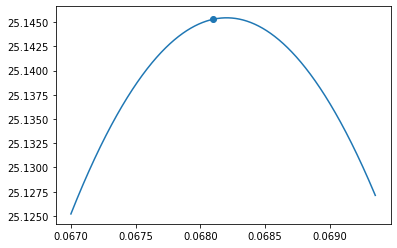

In [131]:
tmp = np.linspace(0.067, 0.06935, 1000)

plt.plot(tmp, f(tmp))
plt.scatter(0.0681, f(0.0681))

In [142]:
bins = np.linspace(-0.1838, 0.32, Nbins)
bins[256]

0.06810000000000002

In [168]:
512/48

10.666666666666666

In [169]:
512 * 3 / 48

32.0

In [196]:
density = 0.485*np.mean(hist_fibre, axis = 0) + 0.465*np.mean(hist_nonfibre, axis = 0)
density = density / ((mids_fibre[1]-mids_fibre[0]) * np.sum(density))

(mids_fibre[1]-mids_fibre[0]) * np.sum(density[mids_fibre > 0])

0.9768992327901018

# Re-sampling into discrete speed classes

In [77]:
densities = []
average_speed_linear = []
average_speed_logarithmic = []

for Nbins in [4, 8, 16, 32, 64, 128, 256, 512]:
    
    bins_positive =  np.logspace(-4, np.log10(0.3), 3*int(Nbins/4) + 1)
    bins_negative =  np.logspace(-4, np.log10(0.1), 1*int(Nbins/4) + 1)
    
    mids_positive_linear =    (bins_positive[1:] + bins_positive[:-1])/2
    mids_negative_linear = -( (bins_negative[1:] + bins_negative[:-1])/2 )[::-1]
    
    mids_positive_logarithmic =    np.sqrt(bins_positive[1:]*bins_positive[:-1])
    mids_negative_logarithmic = -( np.sqrt(bins_negative[1:]*bins_negative[:-1]) )[::-1]
    
    bins_negative = -bins_negative[::-1]

    bins = np.concatenate((bins_negative, bins_positive))
    mids_linear = np.concatenate((mids_negative_linear, [0.0], mids_positive_linear))
    mids_logarithmic = np.concatenate((mids_negative_logarithmic, [0.0], mids_positive_logarithmic))
    
    density = np.zeros(len(bins)-1)

    Nfiles = 500
    for i in trange(Nfiles):
        random_speeds_fibre    = np.load(f'speeds_fibre_{i:04}.npy')
        random_speeds_nonfibre = np.load(f'speeds_nonfibre_{i:04}.npy')
        density += 0.485*np.histogram(random_speeds_fibre,    bins = bins, density = True)[0]
        density += 0.465*np.histogram(random_speeds_nonfibre, bins = bins, density = True)[0]
        
        

    densities.append(density/Nfiles)
    average_speed_linear.append(np.sum(density*mids_linear))
    average_speed_logarithmic.append(np.sum(density*mids_logarithmic))

100%|██████████| 500/500 [01:08<00:00,  7.25it/s]


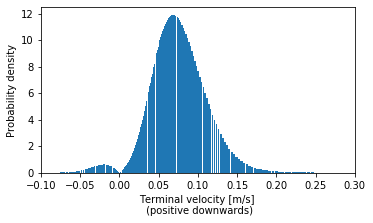

In [89]:
fig = plt.figure(figsize = (5, 3))
mids = (bins[:-1] + bins[1:])/2
wids = bins[1:] - bins[:-1]
plt.bar(mids, densities[-1], width = 0.9*wids)
plt.xlim(-0.1, 0.3)
plt.ylim(-0.04, 12.5)

plt.xlabel('Terminal velocity [m/s] \n (positive downwards)')
plt.ylabel('Probability density')
plt.subplots_adjust(left=0.098, bottom=0.19, right=0.97, top=0.96)
plt.savefig('double-log-distribution.pdf')

TypeError: ylabel() missing 1 required positional argument: 'ylabel'

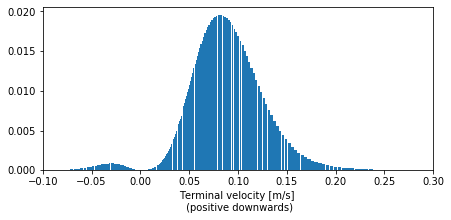

In [70]:
fig = plt.figure(figsize = (7, 3))
mids = (bins[:-1] + bins[1:])/2
wids = bins[1:] - bins[:-1]
plt.bar(mids, densities[-1] / np.sum(densities[-1]), width = 0.9*wids)
plt.xlim(-0.1, 0.3)

plt.xlabel('Terminal velocity [m/s] \n (positive downwards)')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('double-log-distribution.pdf')

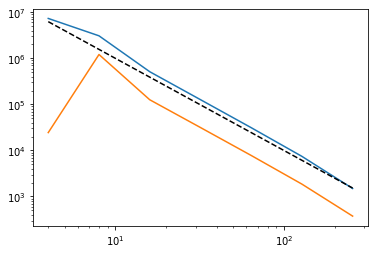

In [57]:
Nclasses = np.array([4, 8, 16, 32, 64, 128, 256, 512], dtype = np.float64)

plt.plot(Nclasses[:-1], np.abs(average_speed_linear - average_speed_linear[-1])[:-1])
plt.plot(Nclasses[:-1], np.abs(average_speed_logarithmic - average_speed_logarithmic[-1])[:-1])

plt.plot(Nclasses[:-1], 1e8*Nclasses[:-1]**(-2), '--', c = 'k')

plt.xscale('log')
plt.yscale('log')



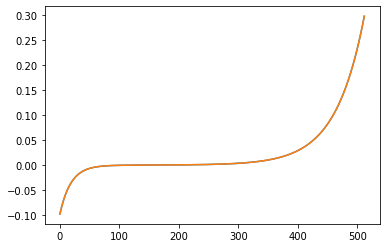

In [50]:
plt.plot(mids_linear)
plt.plot(mids_logarithmic)

In [32]:
for Nbins in [4, 8, 12, 16, 64, 512]:
    bins_positive =  np.logspace(-6, np.log10(0.3), 3*int(Nbins/4) + 1)
    bins_negative = -np.logspace(-6, np.log10(0.1), 1*int(Nbins/4) + 1)[::-1]

    bins = np.concatenate((bins_negative, bins_positive))
    print(len(bins))

6
10
14
18
66
514


In [38]:
counts

array([2.318947e+06, 3.084130e+05, 4.789100e+04, 7.621000e+03,
       1.131000e+03, 1.100000e+01, 0.000000e+00])

In [39]:
4.8e4 / 1e9

4.8e-05

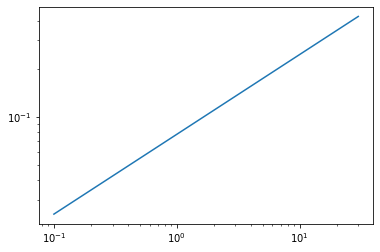

In [62]:
dt = np.logspace(-1, np.log10(30), 100)
plt.plot(dt, np.sqrt(2*3e-3)*np.sqrt(dt))
plt.xscale('log')
plt.yscale('log')

(array([1.29204457, 0.94183267, 0.93410257, 1.03883852, 1.01025641,
        1.00883077, 0.99418061, 1.00498376, 0.9989106 ]),
 array([0.001     , 0.00215443, 0.00464159, 0.01      , 0.02154435,
        0.04641589, 0.1       , 0.21544347, 0.46415888, 1.        ]),
 <a list of 9 Patch objects>)

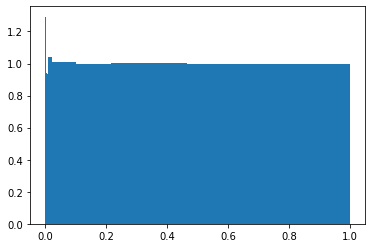

In [73]:
plt.hist(np.random.uniform(0, 1, 100000), bins = np.logspace(-3, 0, 10), density = True)